In [2]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
train_dataset = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),
                                                     transforms.Normalize((0.1307,), (0.3081,))
                                                     ])),
                        batch_size=200, shuffle=True)

test_dataset = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False,
                   transform=transforms.Compose([transforms.ToTensor(),
                                                 transforms.Normalize((0.1307,), (0.3081,))
                                                 ])),
                      batch_size=200, shuffle=True)

In [5]:
class Net(nn.Module):
  def __init__(self):
      super(Net, self).__init__()
      self.fc1 = nn.Linear(28 * 28, 200)
      self.fc2 = nn.Linear(200, 200)
      self.fc3 = nn.Linear(200, 10)

  def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return F.softmax(x)

net = Net()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
criterion = nn.MSELoss()

In [8]:
epochs=15
log_interval=10
accuracy_hist = []
loss_hist = []

for epoch in range(epochs):
      for batch_idx, (data, target) in enumerate(train_dataset):
          v_data, v_target = Variable(data), Variable(F.one_hot(target, num_classes=10).float())
          v_data = v_data.view(-1, 28*28)
          optimizer.zero_grad()
          net_out = net(v_data)
          accuracy = (torch.argmax(net_out, 1) == target).sum()/train_dataset.batch_size
          loss = criterion(net_out, v_target)
          loss.backward()
          optimizer.step()

          accuracy_hist.append(accuracy)
          loss_hist.append(loss.data)
          if batch_idx % log_interval == 0:
              print('epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tAccuracy: {:.6f} '.format(
                  epoch, batch_idx * len(data), len(train_dataset.dataset),
                          100. * batch_idx / len(train_dataset), loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


epoch: 0 [0/60000 (0%)]	Loss: 0.089896 	Accuracy: 0.090000 
epoch: 0 [2000/60000 (3%)]	Loss: 0.090170 	Accuracy: 0.110000 
epoch: 0 [4000/60000 (7%)]	Loss: 0.090087 	Accuracy: 0.085000 
epoch: 0 [6000/60000 (10%)]	Loss: 0.090004 	Accuracy: 0.105000 
epoch: 0 [8000/60000 (13%)]	Loss: 0.089644 	Accuracy: 0.160000 
epoch: 0 [10000/60000 (17%)]	Loss: 0.089410 	Accuracy: 0.145000 
epoch: 0 [12000/60000 (20%)]	Loss: 0.089585 	Accuracy: 0.150000 
epoch: 0 [14000/60000 (23%)]	Loss: 0.089291 	Accuracy: 0.200000 
epoch: 0 [16000/60000 (27%)]	Loss: 0.089404 	Accuracy: 0.155000 
epoch: 0 [18000/60000 (30%)]	Loss: 0.089158 	Accuracy: 0.170000 
epoch: 0 [20000/60000 (33%)]	Loss: 0.089057 	Accuracy: 0.200000 
epoch: 0 [22000/60000 (37%)]	Loss: 0.088776 	Accuracy: 0.245000 
epoch: 0 [24000/60000 (40%)]	Loss: 0.088815 	Accuracy: 0.235000 
epoch: 0 [26000/60000 (43%)]	Loss: 0.088327 	Accuracy: 0.325000 
epoch: 0 [28000/60000 (47%)]	Loss: 0.088176 	Accuracy: 0.345000 
epoch: 0 [30000/60000 (50%)]	Loss: 0

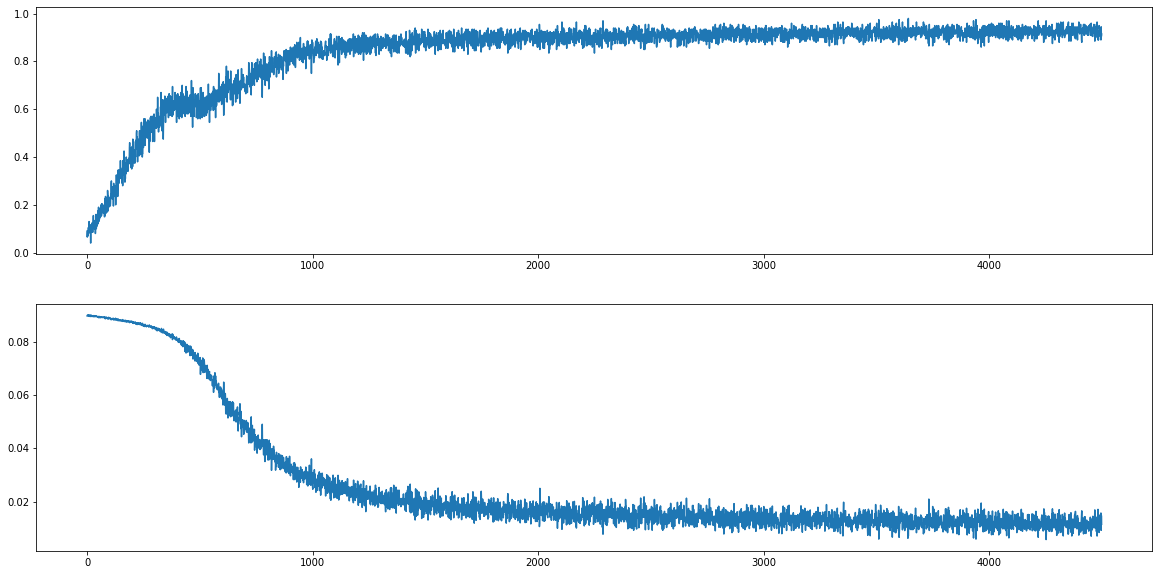

In [9]:
fig = plt.figure(figsize = (20,10))
plt.subplot(2, 1, 1)
plt.plot(accuracy_hist)
plt.subplot(2, 1, 2)
plt.plot(loss_hist)

In [14]:
test_loss = 0
correct = 0

for data, target in test_dataset:
    data, target = Variable(data), Variable(target)
    data = data.view(-1, 28 * 28)
    with torch.no_grad():
      net_out = net(data)
      test_loss += criterion(net_out, Variable(F.one_hot(target, num_classes=10).float())).data
    pred = net_out.data.max(1)[1]
    correct += pred.eq(target.data).sum()

test_loss /= len(test_dataset.dataset)
print('Test set: Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_dataset.dataset),
    100. * correct / len(test_dataset.dataset)))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Test set: Loss: 0.0001, Accuracy: 9279/10000 (93%)



In [15]:
net.eval() 

dummy_input = torch.randn(28 * 28, requires_grad=True)  
  
torch.onnx.export(net, dummy_input, "network.onnx",  
      export_params=True, opset_version=10, do_constant_folding=True,
      input_names = ['modelInput'], output_names = ['modelOutput']) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


In [17]:
test_size = 1000
input = np.zeros([test_size, 28*28])
output = np.zeros([test_size, 10])
for i in range(test_size):
  input[i] = np.array(test_dataset.dataset[i][0][0].view(-1, 28*28))
  output[i][test_dataset.dataset[i][1]] = 1.0

np.save('input', input)
np.save('output', output)